In [53]:
# This script runs simulations to estimate convergence times.
# Running all cells will produce the convergence_times.svg plot in the current folder.

# load libraries
import numpy as np
from functools import partial # partial functions for parallel computation with different parameters
import multiprocess as mp # parallel computation
import matplotlib.pyplot as plt # used for plotting

In [54]:
def run_iteration(R,alpha,A,T,uni_mode,starting_Q,random_starting_Q,iter_num):
    # numpy and random are needed for child processes
    import numpy as np
    from random import random, randint, choice

    # initialize Q-values
    if random_starting_Q:
        Q = np.random.rand(2,2) * (np.max(R)-np.min(R))+np.min(R)
    else:
        Q = np.array([starting_Q,starting_Q])
    starting_Q = Q.copy()
    prev_Q = Q.copy()

    # initialize actions
    ArgmaxQ = [[0,0],[0,0]]
    prev_argmaxQ = ArgmaxQ.copy()
    a=[0,0]
    t_last_change = 0 # period of last action change
    exp_constant = (0.015**(2/T)) # precomputed experimentation constant

    for t in range(T):
        # take actions
        for p in range(2):
            # experiment
            if uni_mode: # uniform
                exp_prob = exp_constant**t

                rdraw = random()
                if rdraw <= exp_prob:
                    a[p] = randint(0,A-1)
                else:
                    a[p] = choice(ArgmaxQ[p])
            else: #logit
                beta = exp_constant**t
                exps = np.exp(Q[p]/beta)
                prs = exps / np.sum(exps)

                rdraw = random()
                if rdraw <= prs[0]:
                    a[p]=0
                else:
                    a[p]=1

        # update Q-values
        for p in range(2):
            prev_Q[p,a[p]] = Q[p,a[p]]
            Q[p,a[p]] = (1-alpha) * Q[p,a[p]] + (alpha) * R[a[p],a[1-p]]

            # find maximal actions for the next period
            MaxQ = np.max(Q,1)
            prev_argmaxQ[p] = ArgmaxQ[p]
            ArgmaxQ[p] = [x for x in range(A) if Q[p,x] == MaxQ[p]]

            # remember the period of the last ction change
            if prev_argmaxQ[p]!= ArgmaxQ[p]:
                t_last_change = t

        # check for convergence
        if t - t_last_change > 10000:
            break

    if t >= T-1: # if the number of iterations was exceeded, rase a warning
        print("Warning: did not converge")
    # return the period of convergence, the final actions and the starting Q-vectors
    return [t,ArgmaxQ,starting_Q]

In [55]:
T = 100000 # maximum number of periods
A = 2 # number of actions

# actions: 0 - Defect, 1 - Cooperate
R = np.zeros([2,2])
R[0,0] = 2 #DD
R[1,0] = 1 #CD
R[0,1] = 4 #DC
R[1,1] = 3 #CC


alpha_list = [x / 100.0 for x in range(5, 100, 5)] # range of learning rates for the simulations
r_list = [x / 10.0 for x in range(11, 30, 1)] #  range of DD payoffs for the simulations

num_iter = 1000 # number of tierations for every parameter pair
uni_mode = False # if true - uniform experimentation, if false - logit experimentation.

# initialize arrays
converged_to = -np.ones([len(alpha_list),len(r_list),num_iter]) # actions onth after convergence
conv_time = -np.ones([len(alpha_list),len(r_list),num_iter]) # time to convergence
starting_Q = [float(R[0,0]),float(R[1,1])] # if random_starting_Q is false then start at these values.
random_starting_Q = True # start at random Q-vectors


with mp.Pool() as pool: #start a parallel pool with processes = number of available CPU's
    for a_ind,alpha in enumerate(alpha_list):
        for r_ind,r_dd in enumerate(r_list):
            R[0,0]=r_dd # set the DD payoff

            # partuial function with current parameters that will be run num_iter times
            func = partial(run_iteration,R,alpha,A,T,uni_mode,starting_Q,random_starting_Q)

            for iter, res in enumerate(pool.map(func, range(num_iter))):
                # record the results
                [t,conv_acts,first_Q] = res

                if conv_acts == [[0],[0]]: # converged to DD
                    converged_to[a_ind,r_ind,iter] = 0
                elif conv_acts == [[1],[1]]: # converged to CC
                    converged_to[a_ind,r_ind,iter] = 1
                else: # failed to converge
                    converged_to[a_ind,r_ind,iter] = -1
                    print("Warning: did not converge")
                conv_time[a_ind,r_ind,iter] = t
                if iter==0:
                    # print one iteration for every parameter pair
                    print("done: ",alpha,r_dd,iter,"result: ",converged_to[a_ind,r_ind,iter],"time: ",t,"start Q: ",first_Q)


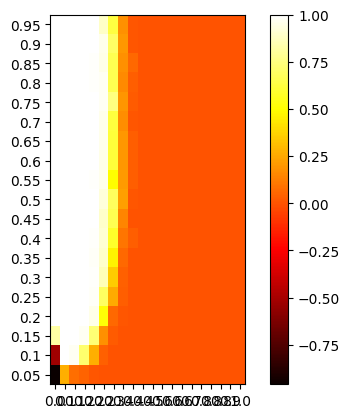

In [56]:
# plot the actions after convergence
fig, ax = plt.subplots(1,1)
img = ax.imshow(np.mean(converged_to,2), origin='lower', cmap='hot', interpolation='nearest', aspect=2)
ax.set_xticks(range(len(r_list)))
ax.set_xticklabels([np.round((x - R[1,0])/(R[1,1] - R[1,0]),1) for x in r_list])
ax.set_yticks(range(len(alpha_list)))
ax.set_yticklabels(alpha_list)
fig.colorbar(img)
plt.show()

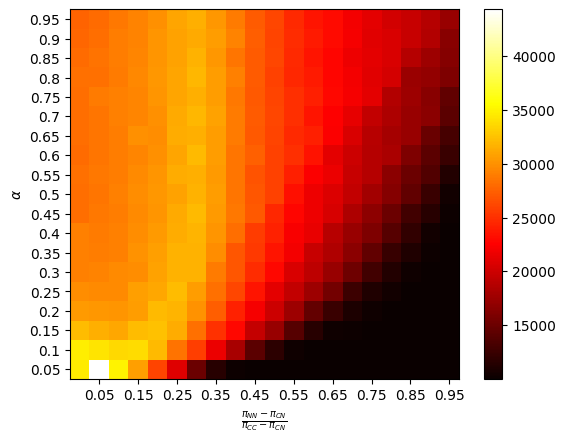

In [11]:
# plot mean convergence times
fig, ax = plt.subplots(1,1)
img = ax.imshow(np.mean(conv_time,2), cmap='hot', origin='lower', interpolation='nearest', aspect=1)
ax.set_xticks(range(1,len(r_list),2))
ax.set_xticklabels([np.round((r_list[x] - R[1,0])/(R[1,1] - R[1,0]),2) for x in range(1,len(r_list),2)])
ax.set_yticks(range(len(alpha_list)))
ax.set_yticklabels(alpha_list)
ax.set_xlabel(r'$\frac{\pi_{NN} - \pi_{CN}}{\pi_{CC} - \pi_{CN}}$')
ax.set_ylabel(r'$\alpha$')
fig.colorbar(img)
plt.show()
fig.savefig("convergence_times.svg", format="svg", dpi=1200)


In [64]:
# optionally save the results using dill
del pool # can't save a pool object
import dill
dill.dump_session('notebook_env.db')

NameError: name 'pool' is not defined

In [8]:
# load dill dump file with
#with open('notebook_env.db', 'rb') as pickle_file:
# dill.load(pickle_file)
